<a href="https://colab.research.google.com/github/jtfields/IST652/blob/master/Copy_of_LA_Traffic_Project_MASTER6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IST 652
Dr. Block
Project - LA Traffic
Tyler Marsh, Jon Kaplan, John Fields
September 4,2019

As the second largest in the United States, Los Angeles has traffic challenges due to a large and growing population and an increase in the number of cars. A better understanding of the factors that contribute to accidents can help government officials, companies, citizens and other interested parties to understand how to make the city safer and more drivable.

The goal is to explore the trends and correlations between the data to provide useful information such as the most dangerous intersections, best/worst times of the day for accidents and other useful information.

Sources
https://www.kaggle.com/joemenifee/traffic-collision-eda

Color themes
https://seaborn.pydata.org/tutorial/color_palettes.html

fonts and searborne themes
https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08

income source: https://data.lacity.org/dataset/Median-Household-Income-by-Council-Districts/khbi-qsyb

Please see the project document in 2U which includes additional information on the introduction, data source, data exploration/cleansing, comparison questions and conclusion.

LOADING AND CLEANING THE DATA

In [0]:
# INSTANT CLEAN
# run this to get cleaned dataset

import pandas as pd
import numpy as np
import ast
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime
import calendar
#import chart_studio.plotly as py
#import plotly.graph_objects as go
import plotly.graph_objs as go
#from plotly.offline import *
import plotly.offline as offline


# Theme and styles for visuals
matplotlib.rcParams['font.family'] = "serif" # font
sns.set_context('talk') # visuals outputted for presentation style
plt.style.use('ggplot')

#Read in the csv with the LA traffic data from 2010-2019
la = pd.read_csv('/Users/johnfields/Desktop/MyPythonFiles/Project/los-angeles-traffic-collision-data/traffic-collision-data-from-2010-to-present.csv')

# add income and clean
income = pd.read_csv("//Users/johnfields/Desktop/MyPythonFiles/Project/los-angeles-traffic-collision-data/LAIncomeCouncil.csv")
# Clean income for calculations and make float type
income["Median Income"] = income["Median Income"].str.replace(",","")
income["Median Income"] = income["Median Income"].str.replace(" ","")
income["Median Income"] = income["Median Income"].str.replace('$','')
income['Median Income'].astype(float)

# merge income into LA dataset using the common column of Council Districts
la = la.merge(income, how = 'inner', on = ['Council Districts'])

# drop columns not used in project
la.drop(["DR Number", 
         "Area ID", 
         "Crime Code", 
         "Crime Code Description",
         "Premise Code",
         "Precinct Boundaries",
         "Date Reported", 
         "Neighborhood Councils (Certified)", 
         "Census Tracts", 
         "MO Codes", 
         "LA Specific Plans",
        "Reporting District"],
        axis=1, inplace=True)

# drop NAs in dataset
la.dropna(inplace=True)

# Victim Age needs to be integer
la['Victim Age'] = la['Victim Age'].astype(int)

# Zip Codes needs to be string
la['Zip Codes'] = la['Zip Codes'].astype(int).astype(str)

# Median Income needs to be float
la['Median Income'] = la['Median Income'].astype(float)

# Council District needs to be integer
la['Council Districts'] = la['Council Districts'].astype(int)

# Handling Date
# format date and time
la['Date'] =  pd.to_datetime(la['Date Occurred'])#, format='%Y/%m/%d')
# break up date to allow more variables for comparison
la['year'] = pd.DatetimeIndex(la['Date']).year # adds years column
la['month'] = pd.DatetimeIndex(la['Date']).month # adds month column
la['weekday']= pd.DatetimeIndex(la['Date']).dayofweek # adds weekday column


# break up by year subsets
la_2015 = la[la['year']== 2015]
la_2016 = la[la['year'] == 2016]
la_2017 = la[la['year'] == 2017]
la_2018 = la[la['year'] == 2018]
la_2019 = la[la['year'] == 2019]

#This was moved to below the weather merge due to conflicts
#making our main dataset only have 2017 and 2018 (due to weather scrape)
#la = la[la['year'] == 2017 & 2018]

# Handling time, getting hours
la["Time Occurred"] = la["Time Occurred"].astype(str)
la["Time Occurred"] = [i[:2] if len(i) == 4 else i[0] for i in la["Time Occurred"]]
la["Time Occurred"] = la["Time Occurred"].astype(int)
la['hours'] = la['Time Occurred'] # adds hours column

# handling location column, break up into lat and long columns
la['Location'] = [ast.literal_eval(x) for x in la.Location]
la['longitude'] = [x['longitude'] for x in la.Location] # adds longitude column
la['latitude'] = [x['latitude'] for x in la.Location] # adds latitude column
la.longitude = la.longitude.astype(float)
la.latitude = la.latitude.astype(float)

# drop more columns not needed
#la = la.drop(['Location',Time Occurred','Date Occurred'],axis=1)
la = la.drop(['Date Occurred'],axis=1)

# confirm data types are changed
la.dtypes

# show final rows and columns for dataset, should now be 382843 rows and 19 columns
dataframe_rows, dataframe_cols = la.shape
print("The dimensions of the cleaned Los Angeles Collision dataset is",dataframe_rows,"rows and",dataframe_cols,"columns.")

The dimensions of the cleaned Los Angeles Collision dataset is 382843 rows and 19 columns.


In [0]:
# Theme and styles for visuals
matplotlib.rcParams['font.family'] = "serif" # font
sns.set_context('talk') # visuals outputted for presentation style
plt.style.use('ggplot')

HANDLING DATA TYPES FOR ANALYSIS

In [0]:
la.head() #show final dataset rows

,Time Occurred,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Address,Cross Street,Location,Zip Codes,Council Districts,Median Income,Date,year,month,weekday,hours,longitude,latitude
0,10,Devonshire,32,F,W,STREET,BALBOA BL,PARTHENIA ST,"{'latitude': '34.2285', 'human_address': '{""ad...",18914,2,55024.39,2019-07-20,2019,7,5,10,-118.5026,34.2285
1,15,Devonshire,78,M,B,STREET,DE SOTO AV,NORDHOFF ST,"{'latitude': '34.2355', 'human_address': '{""ad...",4284,2,55024.39,2019-07-20,2019,7,5,15,-118.5885,34.2355
2,13,Devonshire,45,M,H,STREET,TAMPA AV,NORDHOFF ST,"{'latitude': '34.2355', 'human_address': '{""ad...",18513,2,55024.39,2019-07-19,2019,7,4,13,-118.5536,34.2355
3,8,Devonshire,24,F,H,STREET,LINDLEY AV,NAPA ST,"{'latitude': '34.261', 'human_address': '{""add...",19329,2,55024.39,2019-07-19,2019,7,4,8,-118.4807,34.2610
4,16,Devonshire,35,F,W,STREET,OAKDALE AV,MARILLA ST,"{'latitude': '34.2476', 'human_address': '{""ad...",4284,2,55024.39,2019-07-18,2019,7,3,16,-118.5669,34.2476


In [0]:
summary = la.describe()
summary = summary.transpose()
print(summary)

                      count          mean           std         min  \
Time Occurred      382843.0     13.509990      5.648713      1.0000   
Victim Age         382843.0     41.516771     16.168685     10.0000   
Council Districts  382843.0      8.315022      4.130181      1.0000   
Median Income      382843.0  49545.626366  14782.710308  28883.4100   
year               382843.0   2014.552683      2.771194   2010.0000   
month              382843.0      6.405670      3.427232      1.0000   
weekday            382843.0      2.972898      1.954989      0.0000   
hours              382843.0     13.509990      5.648713      1.0000   
longitude          382843.0   -118.364341      0.104996   -118.6673   
latitude           382843.0     34.083394      0.109050     33.7065   

                          25%         50%         75%         max  
Time Occurred          9.0000     14.0000     18.0000     23.0000  
Victim Age            29.0000     39.0000     51.0000     99.0000  
Council Distri

ANALYSIS: Weather

In [0]:
#Read in the csv with the LA weather data from 2017-2019
weather2017 = pd.read_csv('/Users/johnfields/Library/Mobile Documents/com~apple~CloudDocs/Syracuse/IST652/Project/LA weather data/2017weather.csv')
weather2018 = pd.read_csv('/Users/johnfields/Library/Mobile Documents/com~apple~CloudDocs/Syracuse/IST652/Project/LA weather data/2018weather_clean2.csv')
weather2019 = pd.read_csv('/Users/johnfields/Library/Mobile Documents/com~apple~CloudDocs/Syracuse/IST652/Project/LA weather data/2019weather.csv')
weather = pd.concat([weather2017, weather2018, weather2019])
weather['Date'] =  pd.to_datetime(weather['Date'])
weather['Date'] = weather['Date'].dt.strftime('%Y/%m/%d')

In [0]:
weather.head()

,Unnamed: 0,Date,HighTemp,LowTemp,AverageTemp,Precipitation,NauticalTwilightRise,NauticalTwilightSet
0,0,2017/01/01,55,39,47,0.00,6:01,5:54
1,1,2017/01/02,54,48,51,0.00,6:01,5:55
2,2,2017/01/03,55,45,50,0.00,6:01,5:56
3,3,2017/01/04,57,46,52,0.07,6:02,5:57
4,4,2017/01/05,61,52,56,0.31,6:02,5:57


In [0]:
#Change the weather data type to datetime
weather.Date = pd.to_datetime(weather.Date)
#Merge the la and weather dataframes on date
laWeather = la.merge(weather, how = 'inner', on = ['Date'])

#This was moved to below the weather merge due to conflicts
#making our main dataset only have 2017 and 2018 (due to weather scrape)
la = la[la['year'] == 2017 & 2018]

In [0]:
laWeather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113597 entries, 0 to 113596
Data columns (total 26 columns):
Time Occurred           113597 non-null int64
Area Name               113597 non-null object
Victim Age              113597 non-null int64
Victim Sex              113597 non-null object
Victim Descent          113597 non-null object
Premise Description     113597 non-null object
Address                 113597 non-null object
Cross Street            113597 non-null object
Location                113597 non-null object
Zip Codes               113597 non-null object
Council Districts       113597 non-null int64
Median Income           113597 non-null float64
Date                    113597 non-null datetime64[ns]
year                    113597 non-null int64
month                   113597 non-null int64
weekday                 113597 non-null int64
hours                   113597 non-null int64
longitude               113597 non-null float64
latitude                113597 non-null 

ANALYSIS: Location

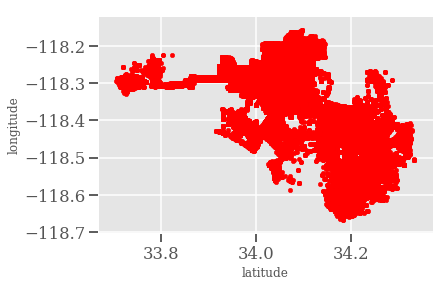

In [0]:
# Create plot of Latitude and Longitude of Accidents
# Import matpolotlib for visualizations
import matplotlib.pyplot as plt
plt.close('all')
laWeather.plot(kind='scatter',x='latitude',y='longitude',color='red')
plt.show()

In [0]:
## Visualize the data with MapBox
# Source of Map Code: https://towardsdatascience.com/famished-on-the-freeway-visualizing-mapping-la-restaurant-inspections-cb6bc8338111
mapbox_token="pk.eyJ1IjoianRmaWVsZHMiLCJhIjoiY2p5dWxxcXJxMDF3ZjNtcm9iYmkyZ2w2ZSJ9.353KtPjbC39lk9uVt3r8PQ"
#data parameters from the file to map
trace = go.Scattermapbox(lat = laWeather["latitude"], lon = laWeather["longitude"], marker=go.Marker(size=10), mode="markers+text")
data = [trace]
#define map layout - access token (API), which location map should be centered on
layout = go.Layout(mapbox=dict(accesstoken=mapbox_token,center=dict(lat=33.9703, lon=-118.2775), zoom=10))
#finalize data and layout
figure = go.Figure(data = data, layout = layout)
#draw the map NOTE: map will open in your default browser - new tab
offline.plot(figure)

#33.9703° N, 118.2775° W - 77th st POLICE STATION

'temp-plot.html'

In [0]:
##Create a different MapBox view of the same data
shaz13_custom_style = "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"
#set the geo=spatial data
data = [go.Scattermapbox(lat = laWeather["latitude"], lon = laWeather["longitude"],mode='markers',
    marker=dict(size= 4,color = 'gold',opacity = .8,),)]
#set the layout to plot
layout = go.Layout(autosize=False,mapbox= dict(accesstoken=mapbox_token,
    bearing=10,pitch=60,zoom=13,center= dict(lat=34.03,lon=-118.46),
    style=shaz13_custom_style),width=900,height=600,title = "LA Traffic Collisions 2017-2019")
fig = dict(data=data, layout=layout)
offline.plot(fig)

'temp-plot.html'

In [0]:
##Create a Map Box plot which also includes weather data
#Hot Days
hot = laWeather[laWeather['HighTemp'] > 100]
#Cool Days
cool = laWeather[laWeather['LowTemp'] < 40]
data = [go.Scattermapbox(
            lat= hot['latitude'] ,
            lon= hot['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'gold',
                opacity = .8),
            name ='Hot'
          ),
        go.Scattermapbox(
            lat= cool['latitude'] ,
            lon= cool['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'cyan',
                opacity = .8),
            name ='Cool'
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken=mapbox_token,
                                bearing=10,
                                pitch=60,
                                zoom=11,
                                center= dict(
                                         lat=34.0482,
                                         lon=-118.4),
                                style= "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"),
                    width=900,
                    height=600, title = "LA Accidents 2017-2019 on Hot and Cool Days")
fig = dict(data=data, layout=layout)
#offline.plot(fig)
plotly.offline.plot(fig, filename='traffic-weather-temp.html')

'traffic-weather-temp.html'

In [0]:
##Create a Map Box plot which also includes weather data
#Sunrise
rain = laWeather[laWeather['Precipitation'] > 0.01]
#Not Rain
notRain = laWeather[laWeather['Precipitation']==0]
data = [go.Scattermapbox(
            lat= rain['latitude'] ,
            lon= rain['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'gold',
                opacity = .8),
            name ='rain'
          ),
        go.Scattermapbox(
            lat= notRain['latitude'] ,
            lon= notRain['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'cyan',
                opacity = .8),
            name ='no rain'
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken=mapbox_token,
                                bearing=10,
                                pitch=60,
                                zoom=11,
                                center= dict(
                                         lat=34.0482,
                                         lon=-118.4),
                                style= "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"),
                    width=900,
                    height=600, title = "LA Accidents 2017-2019 with/without precipitation")
fig = dict(data=data, layout=layout)
#offline.plot(fig)
plotly.offline.plot(fig, filename='traffic-weather.html')

'traffic-weather.html'

ANALYSIS: Time/Date

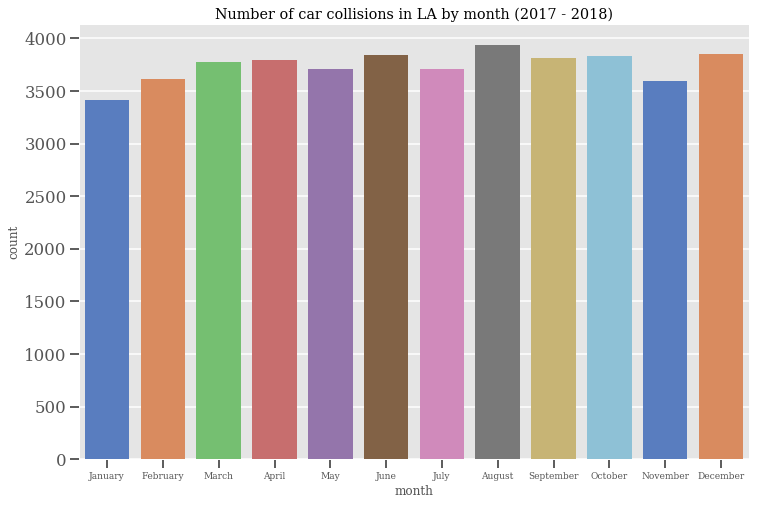

In [0]:
# Time, Collisions by month
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2017 - 2018)');

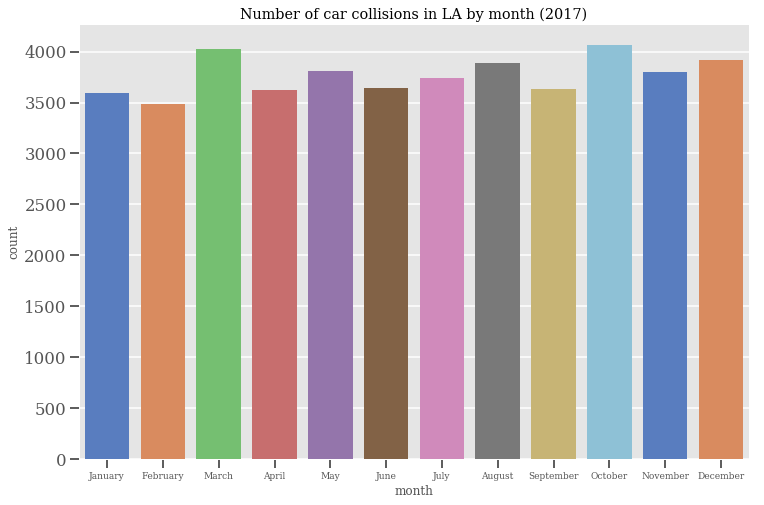

In [0]:
# Collisions by month in 2017 

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la_2017,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2017)');



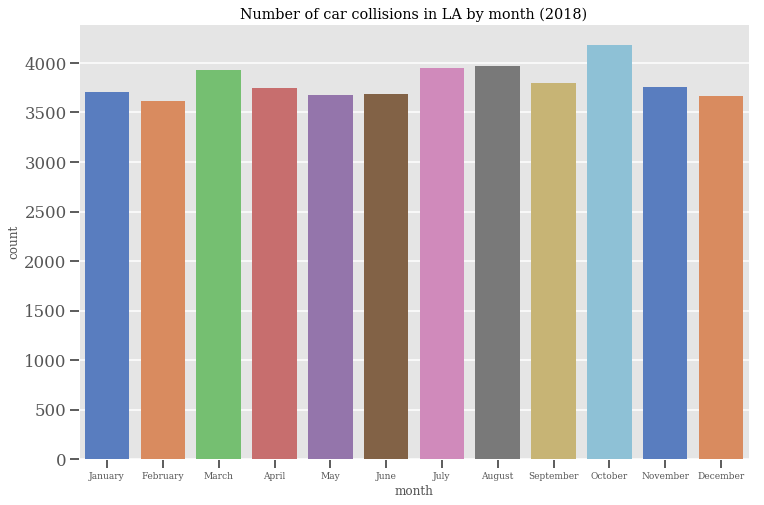

In [0]:
# Collisions by month in 2018

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la_2018,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2018)');

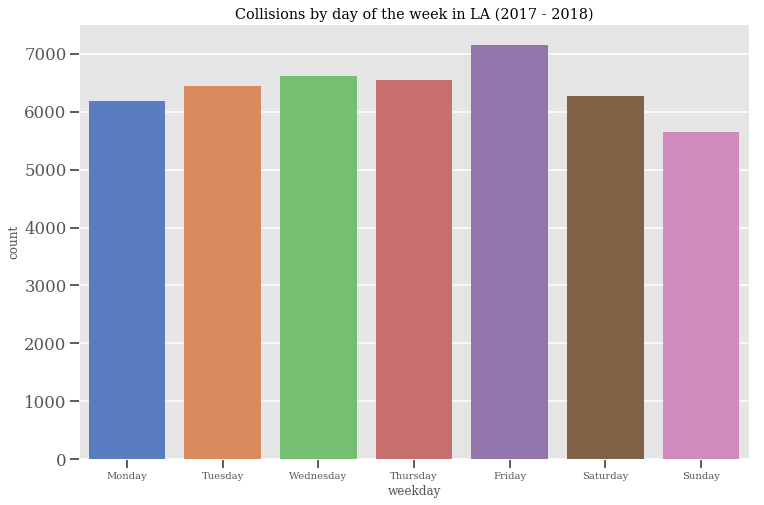

In [0]:
# collisions by weekday
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'weekday',data = la,palette='muted')
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], fontsize=10)
ax.set_title('Collisions by day of the week in LA (2017 - 2018)');

ANALYSIS: Location

77th Street    3088
Wilshire       2805
Southwest      2754
Van Nuys       2459
Olympic        2412
Newton         2350
N Hollywood    2347
West LA        2270
Pacific        2242
Devonshire     2202
West Valley    2147
Mission        2097
Hollywood      2094
Topanga        2082
Central        2072
Northeast      1833
Southeast      1790
Foothill       1566
Harbor         1493
Hollenbeck     1492
Rampart        1265
Name: Area Name, dtype: int64

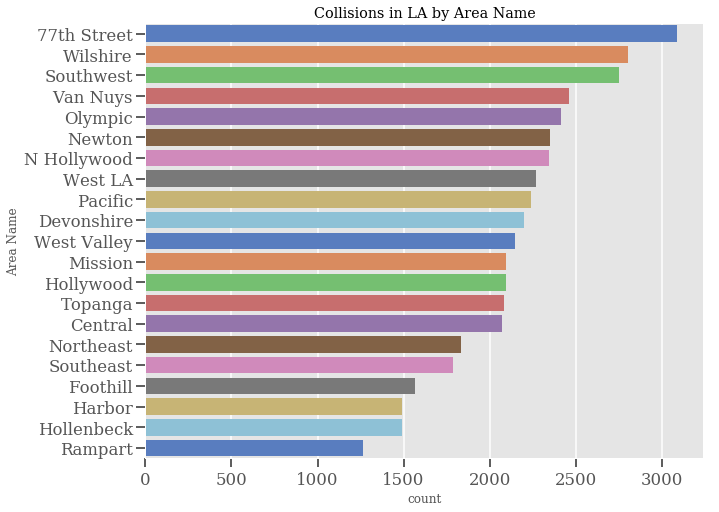

In [0]:
# collisions by area name, descending values, ORDERED

fig,ax = plt.subplots(figsize=(10,8))
descending_order = la['Area Name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,y="Area Name",order=descending_order, palette='muted')
ax.set_title('Collisions in LA by Area Name');

la['Area Name'].value_counts()

12    3856
14    3815
9     3726
13    3711
7     3480
3     3109
6     2945
8     2884
10    2846
5     2839
4     2820
2     2584
15    2243
11    2059
1     1943
Name: Council Districts, dtype: int64

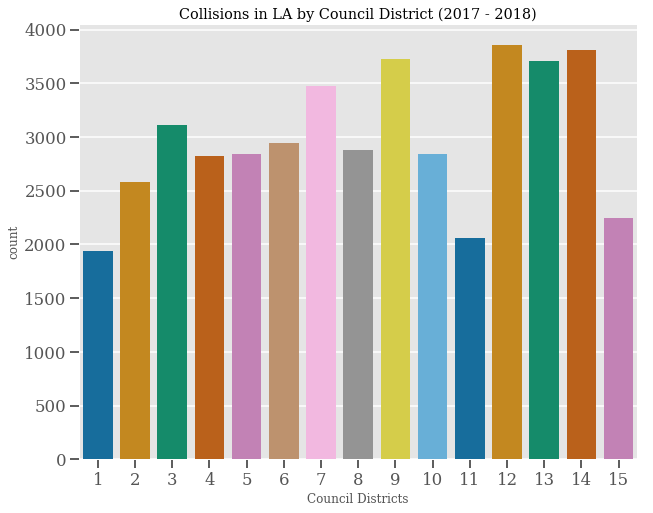

In [0]:
# collisions by council district name
fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Council Districts",data=la,palette='colorblind')
ax.set_title('Collisions in LA by Council District (2017 - 2018)');

la['Council Districts'].value_counts()

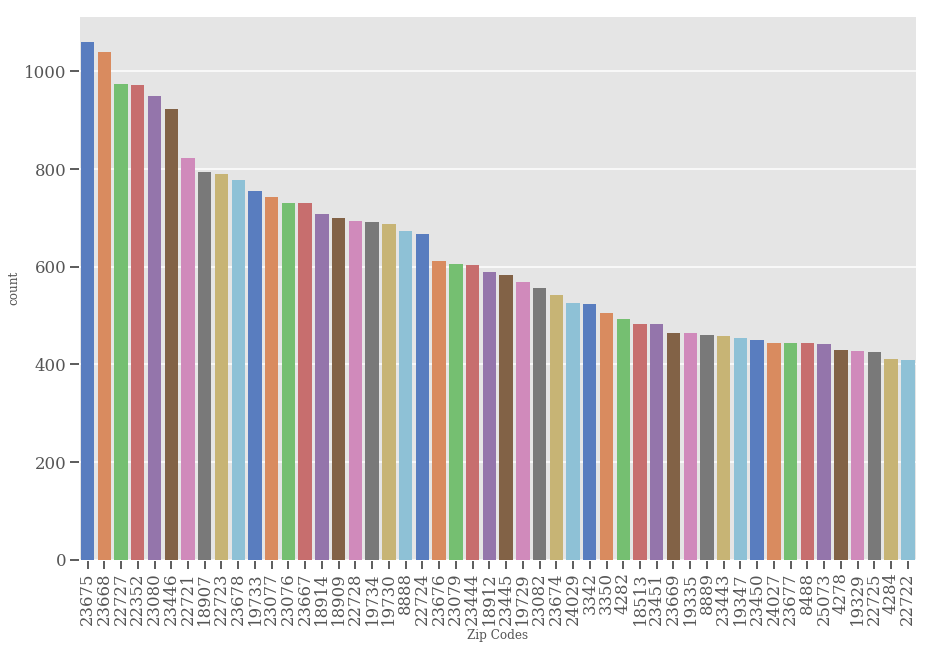

In [0]:
# Collisions by zip code
# TO DO, make top 50, descending order, add title, vertical X axis
descending_order = la['Zip Codes'].value_counts().sort_values(ascending=False).index[:50]
#sns.countplot(data=la,x="Zip Codes",order=descending_order, palette = 'muted')

#sort_values(ascending=0)[:10].plot(kind='bar')

fig,ax = plt.subplots(figsize=(15,10)), plt.xticks(rotation=90)
sns.countplot(x="Zip Codes",data=la, palette='muted', order=descending_order)
#ax.set_title('Collissions in LA by Zip Code (2017 - 2018)');

#la['Zip Codes'].value_counts()

ANALYSIS: Demographics

In [0]:
# Create a bar chart with the number of donors/non-donors by region
la.groupby(['age_by_decade','Victim Sex']).size().unstack().plot(kind='bar',stacked=True)

KeyError: ignored

In [0]:
# Victim age violin plot
#sns.violinplot(x="rank", y="senitment", hue="category", data=df)
sns.violinplot(x='Victim Age', data=la)
#ax.set_title('Victim Age Distribution (2017 - 2018)')

In [0]:
# breakdown of victim races (2017 - 2018)
la['Victim Descent'].value_counts()

In [0]:
#bin victim ages

la['age_by_decade'] = pd.cut(x=la['Victim Age'], bins=[19,29,39,49,59,69,79], labels=['20s','30s','40s','50s','60s','70s'])

In [0]:
# Create bar chart by Victim Race and Age by Decade
la.groupby(['Victim Descent','age_by_decade']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [0]:
# Race and income breakdown 

#la.groupby(['Victim Descent', 'Median Income']).size()

In [0]:
# Victims
# variables with very little count were ommitted, top 5 displayed
fig,ax = plt.subplots(figsize=(12,8))

descending_order = la['Victim Descent'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,x="Victim Descent", palette = 'muted',  order=la['Victim Descent'].value_counts().iloc[:5].index)
ax.set_title('Top 5 Ethnicities of Victims in Colllisions in LA (2017 - 2018)');

In [0]:
# race by age breakdown

# List of races to plot
races = ['A', 'W', 'H', 'B' ]

# Iterate through 
for race in races:
    subset = la[la['Victim Descent'] == race]
    
    # Draw the density plot
    sns.distplot(subset['Victim Age'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = race)
    

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Race and Age (2017 - 2018)')
plt.xlabel('Age')
plt.ylabel('Density')

In [0]:
# race by council district breakdown

# List of races to plot
airlines = ['A', 'W', 'H', 'B' ]




# Iterate through 
for race in races:
    subset = la[la['Victim Descent'] == race]
    
# Draw density plot
    sns.distplot(subset['Council Districts'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = race)
    

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Race and Council Districts (2017 - 2018)')
plt.xlabel('Council Districts')
plt.ylabel('Density')

In [0]:
# income and race breakdown

# List of races to plot
airlines = ['A', 'W', 'H', 'B' ]

# Iterate through
for race in races:
    subset = la[la['Victim Descent'] == race]
    
# Draw the density plot
    sns.distplot(subset['Median Income'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = race)
    

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Race and Median Income (2017 - 2018)')
plt.xlabel('Median Income')
plt.ylabel('Density')

In [0]:
# line chart for victim race and income

#sns.lineplot(x="timepoint", y="signal", data=fmri)

sns.lineplot(x='Victim Descent', y='Median Income', data=la, markers=True, dashes=False)

#plot formatting 
#plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Descent and Median Income (2017 - 2018)')


In [0]:
# Victim's Ages
la['Victim Age'].describe()

In [0]:
# line chart for victim race and income

#sns.lineplot(x="timepoint", y="signal", data=fmri)

sns.lineplot(x='Victim Age', y='Median Income', data=la)

#plot formatting 
#plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Age and Median Income (2017 - 2018)')

In [0]:
# barplot for victim race and income

#sns.lineplot(x="timepoint", y="signal", data=fmri)

#Victim income scatterplot

#ax = sns.scatterplot(x="total_bill", y="tip", hue="time",data=tips)

sns.barplot(y='Median Income', x='Victim Descent', data=la)
#plot formatting 
#plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Race and Median Income (2017 - 2018)')

In [0]:
# Victim's Age Visualization
# why so many 99 year olds?

fig,ax = plt.subplots(figsize=(12,18))
sns.countplot(y="Victim Age",data=la,palette='muted')
ax.set_title('Ages of victims in collisions in LA (2017 - 2018)');

In [0]:
# Victims
# variables with very little count were ommitted, top 5 displayed
fig,ax = plt.subplots(figsize=(12,8))

#descending_order = la['Median Income'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,x="Median Income", palette = 'muted',  order=la['Median Income'].value_counts().iloc[:5].index)
ax.set_title('Distribution of Median Income in Colllisions in LA (2017 - 2018)');

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

a = df.groupby('normal').size()
b = df.groupby('chi').size()

categories = df['normal'].cat.categories
ind = np.array([x for x, _ in enumerate(categories)])
width = 0.35       
plt.bar(ind, a, width, label='Normal')
plt.bar(ind + width, b, width,
    label='Chi Square')

plt.xticks(ind + width / 2, categories)
plt.legend(loc='best')
plt.xticks(rotation = 90)
plt.show()

# Bin income
#df_ages['age_bins'] = pd.cut(x=df_ages['age'], bins=[20, 29, 39, 49])

la['income_bin']=pd.cut(x=la['Median Income'], bins[0, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000])

#pd.cut(df['normal'], 8).head()
#pd.cut(la['Median Income'], 5).head()
custom_bucket_array = np.linspace(0, 20, 9)
custom_bucket_array

income_bucket = np.linspace()

df['normal'] = pd.cut(df['normal'], custom_bucket_array)
df['chi'] = pd.cut(df['chi'], custom_bucket_array)
df.head()

df['normal'] = pd.cut(df['normal'], custom_bucket_array)
df['chi'] = pd.cut(df['chi'], custom_bucket_array)
df.head()

In [0]:
# make bins of Median Income

import matplotlib
plt.style.use('ggplot')
#df_ages['age_bins'] = pd.cut(x=df_ages['age'], bins=[20, 29, 39, 49])
la['income_bins'] = pd.cut(x=la['Median Income'], bins=[20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000], labels=['20-29k', '30-39k', '40-49k', '50-59k', '60-69k', '70-79k', '80-89k'])
#la['Median Income'].round(0)
#la['Median Income'].astype(int)

#la.income_bins.head()



#width = 0.35       
#a = la.groupby('income_bins').size()
#plt.bar(la, a, width, label='Normal')

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Council Districts",data=la,palette='colorblind')
ax.set_title('Collisions in LA by Council District (2017 - 2018)')

ax = la['income_bins'].value_counts(sort=False).plot.bar(rot=0, color='b', figsize=(6,4)), plt.xticks(rotation=90)
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in la['income_bins'].cat.categories])
plt.show()
#ax.set_title('Median Income Binned (2017 - 2018)')
#sns.countplot(data=la,x="Median Income", palette = 'muted',  order=la['Median Income'].value_counts().iloc[:5].index)

In [0]:
# Income Distribution of colission victims

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="income_bins",data=la,palette='colorblind')
ax.set_title('Income Distribution of Colission Victims (2017 - 2018)')




In [0]:
# stacked barchart

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="income_bins",data=la,palette='colorblind')
ax.set_title('Income Distribution of Colission Victims (2017 - 2018)')





from matplotlib.colors import ListedColormap
    la.set_index('Victim Descent')\
      .reindex(la.set_index('Victim Descent').sum().sort_values().index, axis=1)\
      .T.plot(kind='bar', stacked=True,
              colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(12,6))

In [0]:
# Age sorted by collision 


fig,ax = plt.subplots(figsize=(12,18))
descending_order = la['Victim Age'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,y="Victim Age",order=descending_order)
ax.set_title('Age of victim in collisions (2017 - 2018)');

In [0]:
# Age sorted by collision, BINNED 


fig,ax = plt.subplots(figsize=(12,18))
descending_order = la['Victim Age'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,y="Victim Age",order=descending_order)
ax.set_title('Age of victim in collisions (2017 - 2018)');

In [0]:
# Collision by gender

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(data=la,x="Victim Sex",palette='pastel', order=la['Victim Sex'].value_counts().iloc[:2].index)
ax.set_title('Gender of victims in collisions (2017 - 2018)');

In [0]:
#Scatterplots

import seaborn as sns
sns.set(style="ticks")

#df = sns.load_dataset("iris")
#sns.pairplot(df, hue="species")

sns.pairplot(la, hue="Victim Age")

In [0]:
# boxplots

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="distance", y="method", data=planets,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x="distance", y="method", data=planets,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#sns.despine(trim=True, left=True)

In [0]:
#line plots

import seaborn as sns
sns.set(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

In [0]:
sns.lineplot(x='weekday', hue='Victim Age', data=la)

In [0]:
# accidents by race per hour, WIP

accidents_hour_pt = la.pivot_table(index='Victim Descent', columns='hours', aggfunc='size')
accidents_hour_pt = accidents_hour_pt.apply(lambda x: x / accidents_hour_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Average Number of Accidents per Race and Hour', fontsize=14)
sns.heatmap(accidents_hour_pt, cbar=True, annot=False, fmt=".0f");

In [0]:
# accidents by race per month, WIP
accidents_month_pt = la.pivot_table(index='Victim Descent', columns='month', aggfunc='size')
accidents_month_pt = accidents_month_pt.apply(lambda x: x / accidents_month_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Average Number of Accidents per Race and Month', fontsize=14)
sns.heatmap(accidents_month_pt, cbar=True, annot=False, fmt=".0f");

This section includes code to downloads tweets from Twitter with hashtags related to Los Angeles traffic such as #LAtraffic. Hashtags in Twitter are preceded #with the # symbol and are used to group together people who have #similar interests so they can follow others or search based on these hashtags.

In [0]:
from __future__ import print_function 
import tweepy
import json
import pymongo
import folium
from pymongo import MongoClient 
client = MongoClient()

In [0]:
#Part 1 - MongoDB API to Twitter
# MongoDB must be installed locally
# and running a database called 'tweetsdb2'
MONGO_HOST= 'mongodb://localhost/twitterdb2'

In [0]:
WORDS = ['#crash','#traffic','#latraffic','#LAtraffic','#LATraffic24','#LAtraffic24','#lacrash','#laaccident']

In [0]:
CONSUMER_KEY = "LwIB9fmdrqru5FwRc3ommTIQb"
CONSUMER_SECRET = "OcSI7V76IBMy38Nbl7RSikcMMqzs2ewKmQQIUYJhEChloNVMEB"
ACCESS_TOKEN = "28716312-H43y6kJb2mki2dV9hrVWrjymHpF1D9cA0kWX3kfWt"
ACCESS_TOKEN_SECRET = "WDX2dkg3saxwVLFJKpZc5OobybgcsJb0mVvX199qoi55J"

In [0]:
#This is a class to access the Twitter Streaming API. 
class StreamListener(tweepy.StreamListener):   
    def on_connect(self):
        # Called initially to connect to the Streaming API
            print("You are now connected to the streaming API.")
 
    def on_error(self, status_code):
        # On error - if an error occurs, display the error / status code
        print('An Error has occured: ' + repr(status_code))
        return False
 
    def on_data(self, data):
        #This is the meat of the script...it connects to your mongoDB 
        #and stores the tweet
        try:
            client = MongoClient(MONGO_HOST)
            
            # Use twitterdb database. If it doesn't exist, it will 
            #be created.
            db = client.twitterdb2
                
            # Decode the JSON from Twitter
            datajson = json.loads(data)
            
            #grab the 'created_at' data from the Tweet to use for display
            created_at = datajson['created_at']
 
            #print out a message to the screen that we have collected a 
            #tweet
            print("Tweet collected at " + str(created_at))
            
            #insert the data into the mongoDB into a collection called 
            #twitter_search
            #if twitter_search doesn't exist, it will be created.
            db.twitter_search.insert(datajson)
        except Exception as e:
            print(e)

In [0]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
#Set up the listener. The 'wait_on_rate_limit=True' is needed to help 
#with Twitter API rate limiting.
listener = StreamListener(api=tweepy.API(wait_on_rate_limit=True)) 
streamer = tweepy.Stream(auth=auth, listener=listener)
print("Tracking: " + str(WORDS))
streamer.filter(track=WORDS)

Tracking: ['#crash', '#traffic', '#latraffic', '#LAtraffic', '#LATraffic24', '#LAtraffic24', '#lacrash', '#laaccident']
You are now connected to the streaming API.
Tweet collected at Mon Aug 26 04:38:51 +0000 2019


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning:

insert is deprecated. Use insert_one or insert_many instead.



localhost:27017: [Errno 61] Connection refused
Tweet collected at Mon Aug 26 04:39:14 +0000 2019
localhost:27017: [Errno 61] Connection refused
Tweet collected at Mon Aug 26 04:39:17 +0000 2019
localhost:27017: [Errno 61] Connection refused
Tweet collected at Mon Aug 26 04:39:18 +0000 2019
localhost:27017: [Errno 61] Connection refused
Tweet collected at Mon Aug 26 04:40:15 +0000 2019


KeyboardInterrupt: ignored

In [0]:
#Part 2 - Mongo DB Queries
#Stop the collection of tweets in the step above before running these queries

In [0]:
from __future__ import print_function
import tweepy
import json
import pymongo
import folium
from pymongo import MongoClient
client = MongoClient()

In [0]:
client = MongoClient('localhost', 27017)
db = client['twitterdb2']
collection2 = db['twitter_search']
docs = collection2.find()
db.twitterdb2.count_documents

<bound method Collection.count_documents of Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'twitterdb2'), 'twitterdb2')>

In [0]:
for doc in docs:
    print(doc)

ServerSelectionTimeoutError: ignored

In [0]:
collection2.find_one()

ServerSelectionTimeoutError: ignored

In [0]:
tweets_iterator = collection2.find()

for tweet in tweets_iterator:
    print (tweet['text'])

KeyboardInterrupt: ignored

In [0]:
results = collection2.find({'location':'Los Angeles'})

In [0]:
for result in results:
    print(result)

In [0]:
#Create a dataframe with pandas that includes all tweets from this query
import pandas as pd
tweetsdf = pd.DataFrame(list(collection2.find()))

In [0]:
tweetsdf.head()

In [0]:
#Export the tweetsdf data frame to Excel
tweetsdf.to_excel("output.xlsx")

In [0]:
#Query MongoDB for only those tweets with the word crash in the text
from bson.regex import Regex
from pymongo import MongoClient

query = {
    "text": Regex("latraffic","i")
}
sort = [("ID",-1)]
x=0

cursor = collection2.find(query,sort=sort,limit=100)
try:
    for doc in cursor:
        print (doc["text"])
        x=x+1
finally:
    cursor.close()
    print(x)

In [0]:
#client = MongoClient('localhost', 27017)
#db = client['twitterdb2']
#collection = db['twitter_search']
tweets_iterator = collection2.find()

mymap = folium.Map(location=[34.05, -118.4], zoom_start=10)
i = 0
for tweet in tweets_iterator:
    # this code was designed to be able to reduce tweets if needed
    # 0 is used to return all tweets now since the number is small
    if  tweet['coordinates']: #i % 1 == 2 and
        folium.CircleMarker(location=list(reversed(tweet['coordinates']['coordinates'])), radius=2).add_to(mymap)
        i +=1
mymap.save('map.html')
display(mymap)